In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [7]:
P_data1 = pd.read_csv('data/total_precipitation/precip_2000_2011.csv')
P_data2 = pd.read_csv('data/total_precipitation/precip_2012_2023.csv')
P_data = pd.concat([P_data1, P_data2])
P_data.head()

,date,lat,lon,tp
0,2000-01-01,55.25,4.75,0.003465
1,2000-01-01,55.25,5.25,0.003525
2,2000-01-01,55.25,5.75,0.003562
3,2000-01-01,55.25,6.25,0.003803
4,2000-01-01,55.25,6.75,0.004075


In [8]:
P_data['lon'].unique()

array([ 4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
        9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
       13.75, 14.25, 14.75, 15.25])

In [6]:
P_data['lat'].unique()

array([55.25, 54.75, 54.25, 53.75, 53.25, 52.75, 52.25, 51.75, 51.25,
       50.75, 50.25, 49.75, 49.25, 48.75, 48.25, 47.75, 47.25, 46.75,
       46.25, 45.75, 45.25, 44.75])

In [135]:
lat = 53.25
lon = 10.25
P_sample = P_data[(P_data['lon'] == lon) & (P_data['lat'] == lat)]
P_sample['date'] = pd.to_datetime(P_sample['date'])
P_sample.set_index('date', inplace=True)
P_sample['rolling_std_month'] = P_sample['tp'].rolling(window=30).std()
P_sample['rolling_std_year'] = P_sample['tp'].rolling(window=365).std()

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21740\475892272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_sample['date'] = pd.to_datetime(P_sample['date'])
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21740\475892272.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_sample['rolling_std_month'] = P_sample['tp'].rolling(window=30).std()
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_21740\475892272.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

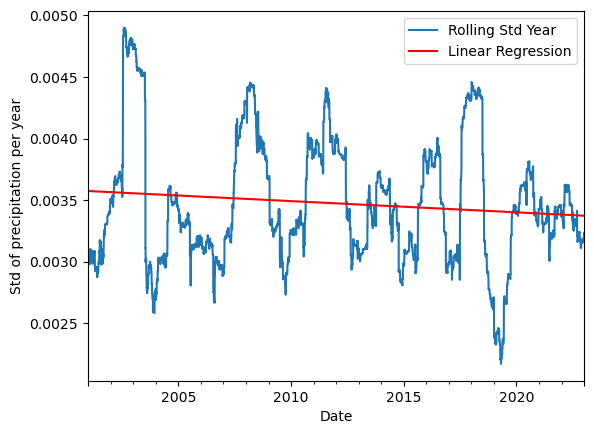

In [95]:
P_sample_clean = P_sample.dropna(subset=['rolling_std_year'])

# Fit a linear regression line
x = np.array(range(len(P_sample_clean.index)))
y = P_sample_clean['rolling_std_year'].values
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Plot the data and the regression line
P_sample_clean['rolling_std_year'].plot(label='Rolling Std Year')
plt.plot(P_sample_clean.index, polynomial(x), color='red', label='Linear Regression')
plt.xlabel('Date')
plt.ylabel('Std of precipitation per year')
plt.legend()
plt.show()

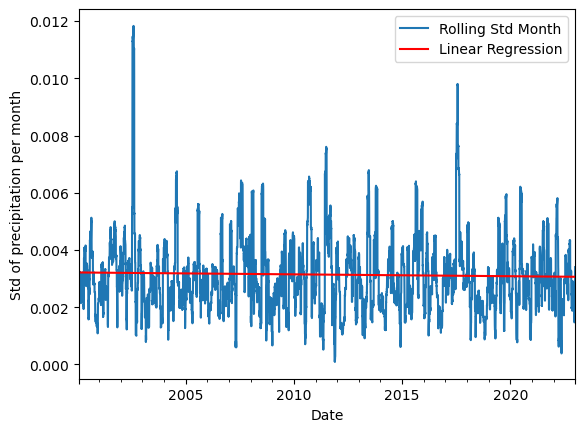

In [96]:
P_sample_clean = P_sample.dropna(subset=['rolling_std_month'])

# Fit a linear regression line
x = np.array(range(len(P_sample_clean.index)))
y = P_sample_clean['rolling_std_month'].values
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Plot the data and the regression line
P_sample_clean['rolling_std_month'].plot(label='Rolling Std Month')
plt.plot(P_sample_clean.index, polynomial(x), color='red', label='Linear Regression')
plt.xlabel('Date')
plt.ylabel('Std of precipitation per month')
plt.legend()
plt.show()

In [132]:
trends_df = {
    'lat': [],
    'lon': [],
    'trend_coef': [],
    'trend_p_value': [] 
}

for (lat, lon), P_sample in P_data.groupby(['lat', 'lon']):
    P_sample['rolling_std_year'] = P_sample['tp'].rolling(window=365).std()

    # Fit a linear model
    P_sample = P_sample.dropna(subset=['rolling_std_year'])
    x = np.array(range(len(P_sample.index)))
    X = sm.add_constant(x)
    y = P_sample['rolling_std_year'].values
    model = sm.OLS(y, X).fit()

    trends_df['lat'].append(lat)
    trends_df['lon'].append(lon)
    trends_df['trend_coef'].append(model.params[1])
    trends_df['trend_p_value'].append(model.pvalues[1])


In [133]:
# Iteriere über die Werte im Dictionary
for key, value in trends_df.items():
    # Überprüfe, ob der Schlüssel 'trend_p_value' ist und ob der Wert größer als 0.05 ist
    if key == 'trend_p_value':
        for i, val in enumerate(value):
            if val > 0.05:
                # Setze NA-Wert in 'trend_coefficient' ein
                trends_df['trend_coef'][i] = np.nan


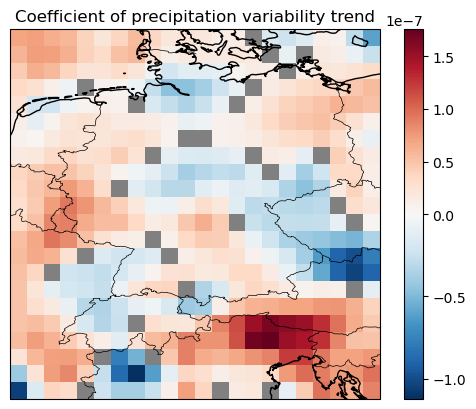

In [139]:
# Create a DataArray with latitude, longitude, and the value
data_array = xr.DataArray(np.reshape(list(trends_df['trend_coef']),(len(np.unique(trends_df['lon'])), len(np.unique(trends_df['lat'])))),
                          coords={'lat': np.unique(trends_df['lat']), 'lon': np.unique(trends_df['lon'])},
                          dims=['lat', 'lon'])

# Create a figure and a set of subplots
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.coastlines()

# Define color map
cmap = plt.cm.RdBu_r
cmap.set_bad(color='gray')

# Plot the data
norm = TwoSlopeNorm(vmin=data_array.min(), vcenter=0, vmax=data_array.max())
data_array.plot.imshow(x='lon', y='lat', norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), ax=ax)

plt.title('Coefficient of precipitation variability trend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

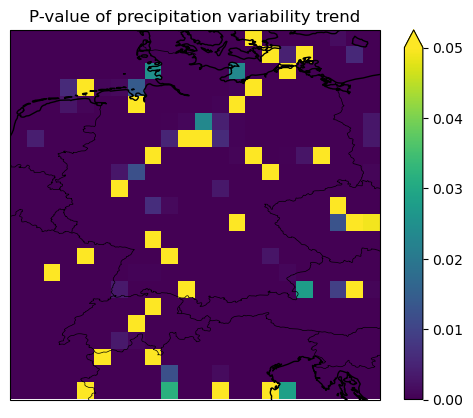

In [125]:
# Create a DataArray with latitude, longitude, and the value
data_array = xr.DataArray(np.reshape(list(trends_df['trend_p_value']),(len(np.unique(trends_df['lon'])), len(np.unique(trends_df['lat'])))),
                          coords={'lat': np.unique(trends_df['lat']), 'lon': np.unique(trends_df['lon'])},
                          dims=['lat', 'lon'])

# Create a figure and a set of subplots
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.coastlines()


# Plot the data
data_array.plot.imshow(x='lon', y='lat', cmap='viridis', transform=ccrs.PlateCarree(), ax=ax, vmax=0.05)

plt.title('P-value of precipitation variability trend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()